In [1]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from torch_geometric.nn import GATConv
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold
import torch.optim as optim
from torch_geometric.data import DataLoader 

In [20]:
data_path = 'NCSU-DigIC-GraphData-2023-07-25/'

In [21]:
def instances_ini(i):
    with gzip.open(data_path + 'xbar/' + str(i) + '/xbar.json.gz','rb') as f:
        design = json.loads(f.read().decode('utf-8'))
        
    instances = pd.DataFrame(design['instances'])
    nets = pd.DataFrame(design['nets'])

    conn=np.load(data_path + 'xbar/' + str(i) + '/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)

    def buildBST(array,start=0,finish=-1):
        if finish<0:
            finish = len(array)
        mid = (start + finish) // 2
        if mid-start==1:
            ltl=start
        else:
            ltl=buildBST(array,start,mid)
        
        if finish-mid==1:
            gtl=mid
        else:
            gtl=buildBST(array,mid,finish)
            
        return((array[mid],ltl,gtl))

    congestion_data = np.load(data_path + 'xbar/' + str(i) + '/xbar_congestion.npz')
    xbst=buildBST(congestion_data['xBoundaryList'])
    ybst=buildBST(congestion_data['yBoundaryList'])
    demand = np.zeros(shape = [instances.shape[0],])
    capacity = np.zeros(shape = [instances.shape[0],])


    def getGRCIndex(x,y,xbst,ybst):
        while (type(xbst)==tuple):
            if x < xbst[0]:
                xbst=xbst[1]
            else:
                xbst=xbst[2]
                
        while (type(ybst)==tuple):
            if y < ybst[0]:
                ybst=ybst[1]
            else:
                ybst=ybst[2]
                
        return ybst, xbst

    for k in range(instances.shape[0]):
        # print(k)
        xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
        i,j=getGRCIndex(xloc,yloc,xbst,ybst)
        d = 0 
        c = 0
        for l in list(congestion_data['layerList']): 
            lyr=list(congestion_data['layerList']).index(l)
            d += congestion_data['demand'][lyr][i][j]
            c += congestion_data['capacity'][lyr][i][j]
        demand[k] = d
        capacity[k] = c
            
    instances['routing_demand'] = demand
    instances['routing_capacity'] = capacity
    instances['congestion'] = demand - capacity
    return instances, A

In [22]:
def cell_ini(i):
    with gzip.open(data_path + 'cells.json.gz','rb') as f:
        cells = json.loads(f.read().decode('utf-8'))

    cells = pd.DataFrame(cells)
    return cells

In [23]:
def norm_ohe(new_instances):
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()
    scaler = MinMaxScaler()
    new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']])
    #test for non transforming
    # new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']]
    return new_instances, orient

In [107]:
data = []
instance_lst = []
for i in range(0, 13):
    print(i)
    instances, A = instances_ini(i+1)
    instance_lst.append(instances)
    cells = cell_ini(i+1)
    new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
    new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height', 'orient']]
    new_instances, orient = norm_ohe(new_instances)
    y = new_instances[:,2]
    # remove congestion from new_instances
    node_features = np.delete(new_instances, 2, 1)
    node_features = np.concatenate((node_features, orient), axis=1)
    source_nodes, target_nodes = np.nonzero(A)
    edge_index = np.vstack((source_nodes, target_nodes))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    reverse_edge_index = torch.stack((edge_index[1], edge_index[0]), dim=0)  # Flip each edge
    bidirectional_edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    data.append(Data(x=x, edge_index=bidirectional_edge_index, y=y))


0
1
2
3
4
5
6
7
8
9
10
11
12


In [547]:
instances, A = instances_ini(1)
cells = cell_ini(1)
new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height', 'orient']]
# new_instances, orient = norm_ohe(new_instances)
new_instances

,xloc,yloc,congestion,width,height,orient
0,41984,44544,-8.0,2176,1536,0
1,41984,47616,-5.0,2176,1536,6
2,44160,44544,-10.0,2176,1536,0
3,44160,47616,-11.0,2176,1536,0
4,46336,47616,-2.0,2176,1536,0
...,...,...,...,...,...,...
3947,21888,53760,0.0,512,1536,4
3948,33664,66048,0.0,512,1536,0
3949,23296,66048,-2.0,384,1536,0
3950,40576,44544,-5.0,640,1536,0


# LOOCV

In [113]:
data

[Data(x=[3952, 8], edge_index=[2, 282944], y=[3952]),
 Data(x=[6872, 8], edge_index=[2, 230840], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 252162], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 241858], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 242188], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 233184], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 244670], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 238776], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 239304], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 243676], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 231608], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 231106], y=[6529]),
 Data(x=[6548, 8], edge_index=[2, 227252], y=[6548])]

In [114]:
train_data = data[1:]
train_data

[Data(x=[6872, 8], edge_index=[2, 230840], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 252162], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 241858], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 242188], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 233184], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 244670], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 238776], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 239304], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 243676], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 231608], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 231106], y=[6529]),
 Data(x=[6548, 8], edge_index=[2, 227252], y=[6548])]

In [115]:
test_data

[Data(x=[3952, 8], edge_index=[2, 282944], y=[3952])]

---
# GCN (four layers)

In [111]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv4(x, edge_index)

        return x



In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GCN model
model = GCN(
    in_channels=8, 
    hidden_channels=64, 
    out_channels=1, 
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

loss_values = []

model.train()
for epoch in range(500):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.y.view(-1, 1))  # Ensure the target shape matches the output
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Adjust learning rate
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

Epoch 1, Average Loss: 0.16660802128414312
Epoch 2, Average Loss: 0.08921145802984635
Epoch 3, Average Loss: 0.05326315729568402
Epoch 4, Average Loss: 0.053997669058541455
Epoch 5, Average Loss: 0.047256135692199074
Epoch 6, Average Loss: 0.0442950806270043
Epoch 7, Average Loss: 0.042632959162195526
Epoch 8, Average Loss: 0.03898909206812581
Epoch 9, Average Loss: 0.03740128160764774
Epoch 10, Average Loss: 0.03552582456419865
Epoch 11, Average Loss: 0.03397394825393955
Epoch 12, Average Loss: 0.03286294328669707
Epoch 13, Average Loss: 0.03197018584857384
Epoch 14, Average Loss: 0.0308668512540559
Epoch 15, Average Loss: 0.030359024026741583
Epoch 16, Average Loss: 0.029464559784779947
Epoch 17, Average Loss: 0.029234803126504023
Epoch 18, Average Loss: 0.02854789902145664
Epoch 19, Average Loss: 0.02790243582179149
Epoch 20, Average Loss: 0.02747031534090638
Epoch 21, Average Loss: 0.027273996577908594
Epoch 22, Average Loss: 0.026738132971028488
Epoch 23, Average Loss: 0.026452330

In [116]:
def evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for graph_data in data_list:
            graph_data = graph_data.to(device)
            # Ensure targets are on the same device as the model output
            graph_data.y = graph_data.y.to(device)
            out = model(graph_data)
            loss = F.mse_loss(out, graph_data.y.view_as(out)) 
            total_loss += loss.item()
            predictions.append(out.cpu().detach().numpy())
    avg_loss = total_loss / len(data_list)
    return avg_loss, predictions

test_loss, predictions = evaluate_model(model, test_data, device)
print(f'Test Loss: {test_loss}')


Test Loss: 0.020679481327533722


In [117]:
predictions[0].shape

(3952, 1)

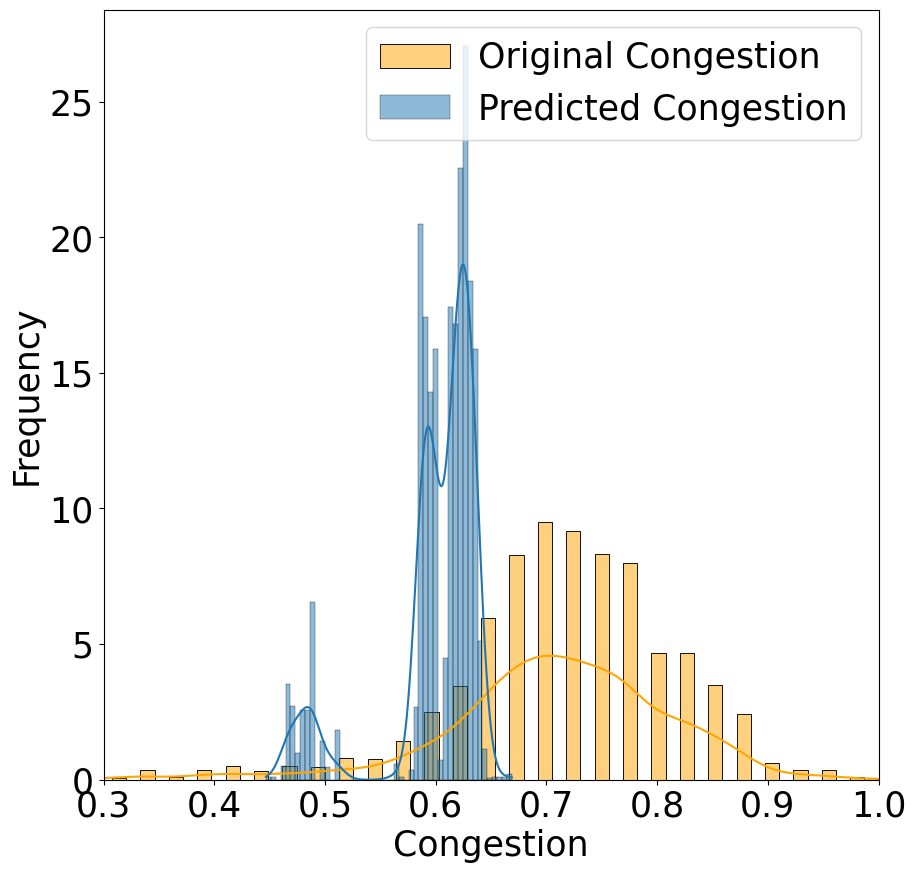

In [238]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [80]:
congestion_scaler = MinMaxScaler()
congestion_scaler.fit(instance_lst[0][['congestion']].values)
temp = congestion_scaler.inverse_transform(predictions[0])

In [ ]:
from sklearn.metrics import mean_squared_error
gcn_mse = mean_squared_error(instance_lst[0][['congestion']].values, temp)
gcn_mse


18.10850785141095

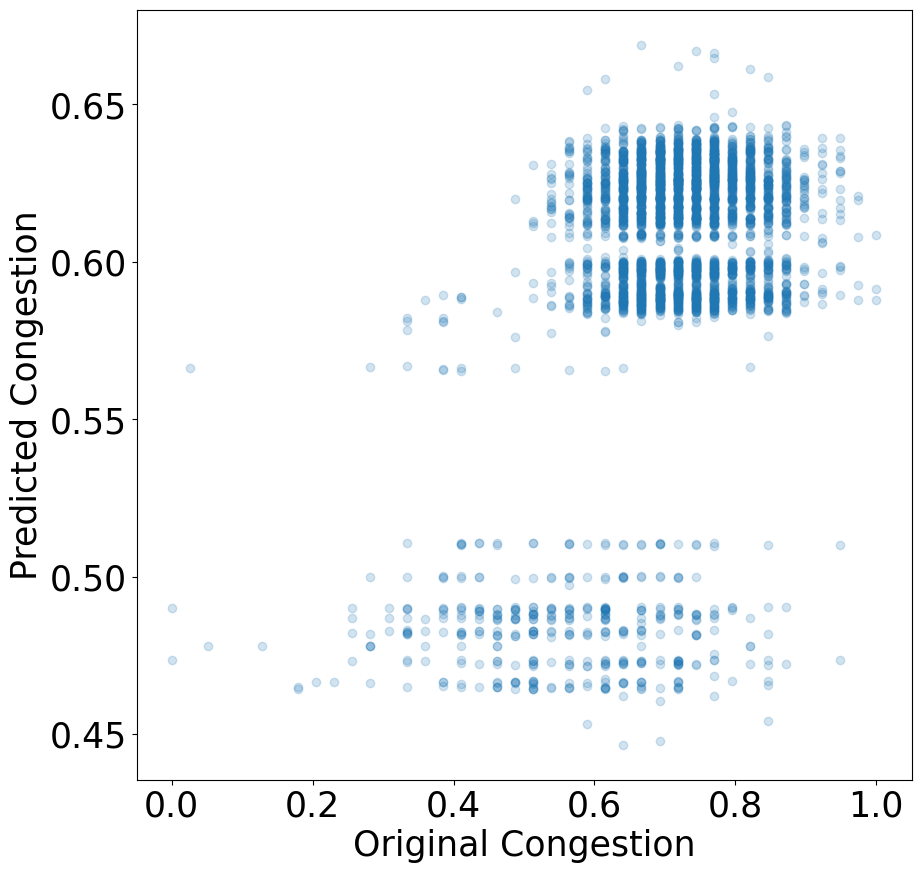

In [240]:
plt.figure(figsize=(10, 10))
plt.scatter(data[0].y.cpu().detach().numpy(), predictions[0], alpha=0.2)
plt.xlabel('Original Congestion', fontsize=25)
plt.ylabel('Predicted Congestion', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [221]:
predictions[0].flatten()

array([0.447938  , 0.47558594, 0.4466477 , ..., 0.5856852 , 0.46209556,
       0.49722254], dtype=float32)

In [223]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
gcn_true_values = data[0].y.cpu().detach().numpy()  # Replace with actual reference to your true congestion values
gcn_predicted_values = np.array(predictions[0].flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
gcn_correlation_matrix = np.corrcoef(gcn_true_values, gcn_predicted_values)
gcn_correlation_coefficient = gcn_correlation_matrix[0, 1]

# Coefficient of determination, R^2
gcn_coefficient_of_determination = np.square(gcn_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {gcn_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {gcn_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): 0.455146875871887
Coefficient of Determination (R²): 0.20715867861593892


---
# GCN with single file

In [141]:
gcn_single = data[0]
gcn_single

Data(x=[3952, 8], edge_index=[2, 282944], y=[3952], train_mask=[3952], val_mask=[3952], test_mask=[3952])

In [134]:
num_nodes = 3952  
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
gcn_single.train_mask = train_mask
gcn_single.val_mask = val_mask
gcn_single.test_mask = test_mask

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GCN model
gcn1_model = GCN(
    in_channels=8, 
    hidden_channels=64, 
    out_channels=1, 
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(gcn1_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

gcn_single.to(device)


for epoch in range(800):
    gcn1_model.train()
    optimizer.zero_grad()
    
    gcn1_out = gcn1_model(gcn_single)  # Assuming your model's forward pass can handle the entire graph
    loss = F.mse_loss(gcn1_out[gcn_single.train_mask], gcn_single.y[gcn_single.train_mask].to(device))
    loss.backward()
    optimizer.step()

    scheduler.step()
    
    # Validation phase
    gcn1_model.eval()
    with torch.no_grad():
        gcn1_val_out = gcn1_model(gcn_single)
        val_loss = F.mse_loss(gcn1_val_out[gcn_single.val_mask], gcn_single.y[gcn_single.val_mask].to(device))
        # Calculate validation metrics as needed
    
    # Print or log your training and validation loss
    print(f'Epoch {epoch+1}: Training Loss {loss.item()}, Validation Loss {val_loss.item()}')


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1371329437.py:22: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(gcn1_out[gcn_single.train_mask], gcn_single.y[gcn_single.train_mask].to(device))
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1371329437.py:32: UserWarning: Using a target size (torch.Size([395])) that is different to the input size (torch.Size([395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(gcn1_val_out[gcn_single.val_mask], gcn_single.y[gcn_single.val_mask].to(device))


Epoch 1: Training Loss 0.48769715428352356, Validation Loss 0.2607719898223877
Epoch 2: Training Loss 0.24916595220565796, Validation Loss 0.10937069356441498
Epoch 3: Training Loss 0.10363375395536423, Validation Loss 0.06541845202445984
Epoch 4: Training Loss 0.06508756428956985, Validation Loss 0.12097704410552979
Epoch 5: Training Loss 0.1261477768421173, Validation Loss 0.11609777808189392
Epoch 6: Training Loss 0.12487338483333588, Validation Loss 0.07888256758451462
Epoch 7: Training Loss 0.08050845563411713, Validation Loss 0.06059374287724495
Epoch 8: Training Loss 0.05981818959116936, Validation Loss 0.06474736332893372
Epoch 9: Training Loss 0.060813870280981064, Validation Loss 0.07545281201601028
Epoch 10: Training Loss 0.07079574465751648, Validation Loss 0.07894464582204819
Epoch 11: Training Loss 0.07360631972551346, Validation Loss 0.07389228045940399
Epoch 12: Training Loss 0.06977729499340057, Validation Loss 0.06479551643133163
Epoch 13: Training Loss 0.062159448862

In [196]:
gcn1_model.eval()

with torch.no_grad():
    # Get model predictions. Here, make sure to use your actual model variable and data object
    gcn1_out = gcn1_model(gcn_single)
    # Calculate the Mean Squared Error (MSE) loss on the test set
    # Adjust this line to match your data object's actual test mask and labels
    gcn1_loss = F.mse_loss(gcn1_out[gcn_single.test_mask], gcn_single.y[gcn_single.test_mask])
    # Print the test loss
    print(f'Test Loss: {gcn1_loss.item()}')


Test Loss: 0.019541431218385696


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/3153771167.py:8: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  gcn1_loss = F.mse_loss(gcn1_out[gcn_single.test_mask], gcn_single.y[gcn_single.test_mask])


In [197]:
gcn1_pred = gcn1_out[gcn_single.test_mask].detach().cpu().numpy()

In [198]:
len(gcn1_pred)

396

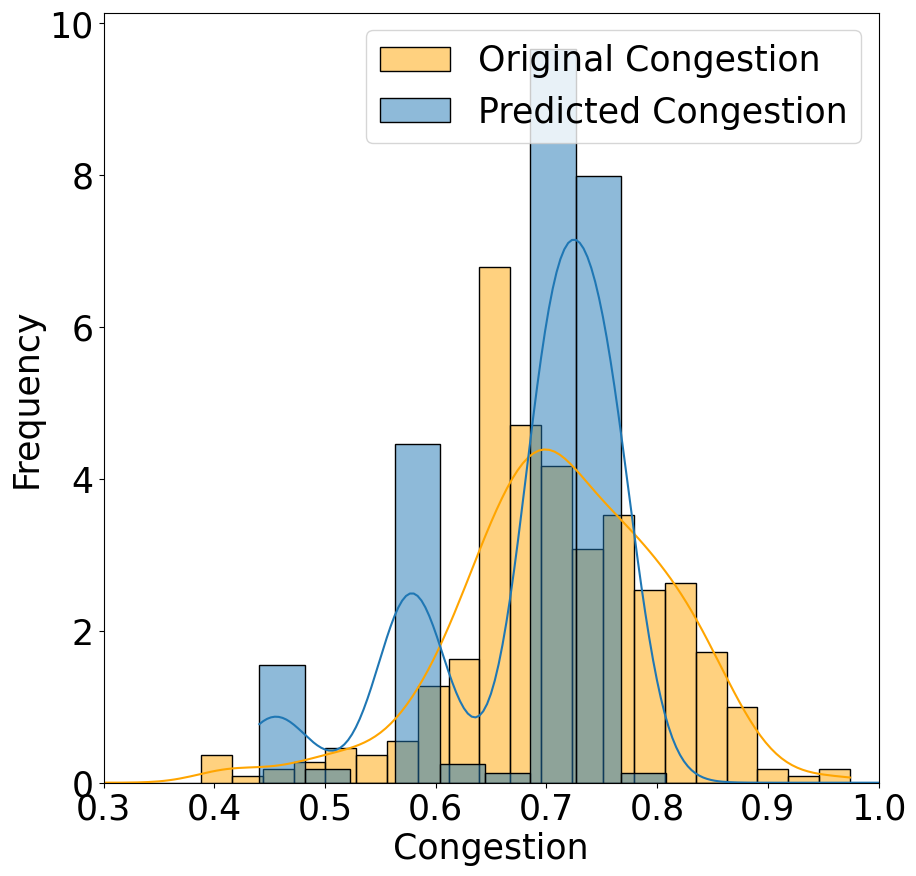

In [237]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y[gcn_single.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(gcn1_pred, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [202]:
gcn_single_inversed = congestion_scaler.inverse_transform(gcn1_pred)
gcn_single_mse = mean_squared_error(instance_lst[0][['congestion']].values[gcn_single.test_mask], gcn_single_inversed)
gcn_single_mse

30.142932044968862

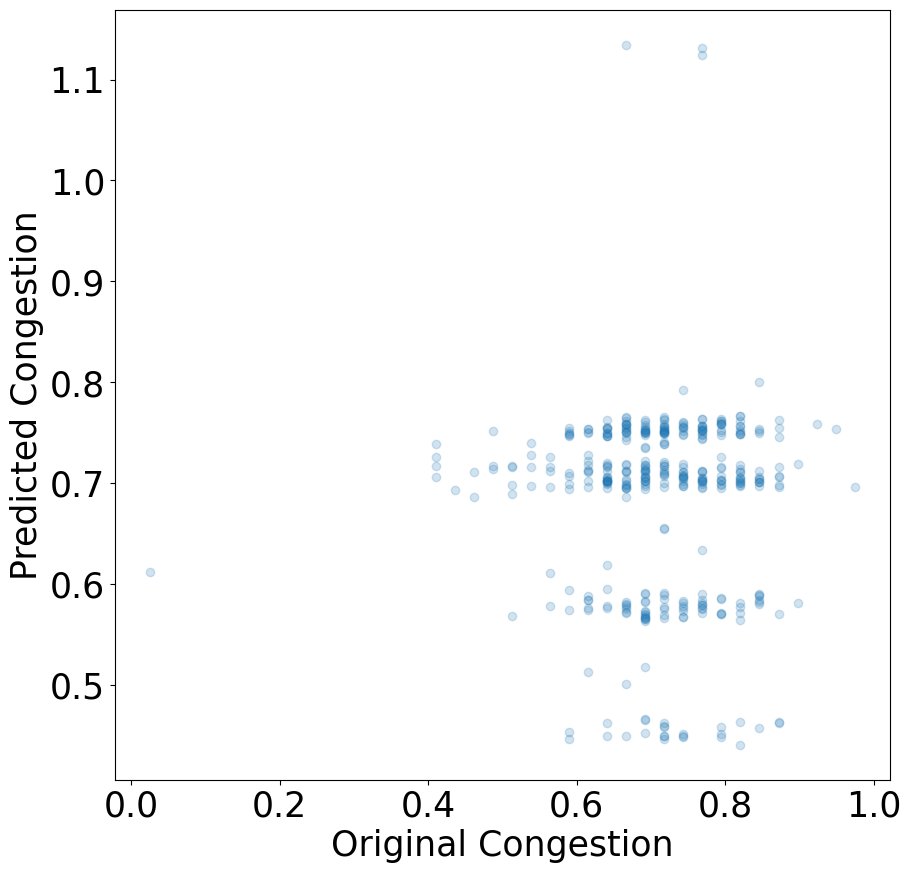

In [241]:
plt.figure(figsize=(10, 10))
plt.scatter(data[0].y[gcn_single.test_mask].cpu().detach().numpy(), gcn1_pred, alpha=0.2)
plt.xlabel('Original Congestion', fontsize=25)
plt.ylabel('Predicted Congestion', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [242]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
gcn1_true_values = data[0].y[gcn_single.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
gcn1_predicted_values = np.array(gcn1_pred.flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
gcn1_correlation_matrix = np.corrcoef(gcn1_true_values, gcn1_predicted_values)
gcn1_correlation_coefficient = gcn1_correlation_matrix[0, 1]

# Coefficient of determination, R^2
gcn1_coefficient_of_determination = np.square(gcn1_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {gcn1_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {gcn1_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): -0.014749512966378931
Coefficient of Determination (R²): 0.00021754813274538022


---

# GAT (across files)

In [159]:
class DeeperGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3, out_channels, heads_1=1, heads_2=1, heads_3=1, heads_4=1, dropout=0.4):
        super(DeeperGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels_1, heads=heads_1, dropout=dropout)
        # Adjusted for multi-head output
        self.conv2 = GATConv(hidden_channels_1 * heads_1, hidden_channels_2, heads=heads_2, dropout=dropout)
        # Further layers added
        self.conv3 = GATConv(hidden_channels_2 * heads_2, hidden_channels_3, heads=heads_3, dropout=dropout)
        self.conv4 = GATConv(hidden_channels_3 * heads_3, out_channels, heads=heads_4, concat=False, dropout=dropout)  # concat=False in the last layer to not multiply output dimensions
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        # Layer 2
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        # Layer 3
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        # Layer 4
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv4(x, edge_index)
        return x


In [160]:
train_data

[Data(x=[6872, 8], edge_index=[2, 230840], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 252162], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 241858], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 242188], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 233184], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 244670], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 238776], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 239304], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 243676], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 231608], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 231106], y=[6529]),
 Data(x=[6548, 8], edge_index=[2, 227252], y=[6548])]

In [161]:
test_data

[Data(x=[3952, 8], edge_index=[2, 282944], y=[3952])]

In [162]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted to match DeeperGAT class
gat_model = DeeperGAT(
    in_channels=8, 
    hidden_channels_1=32, 
    hidden_channels_2=32, 
    hidden_channels_3=32, 
    out_channels=1, 
    heads_1=4, 
    heads_2=4, 
    heads_3=4, 
    heads_4=1,  # Typically, you might not use multiple heads in the final layer
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

loss_values = []

gat_model.train()
for epoch in range(500):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)
        optimizer.zero_grad()
        out = gat_model(graph_data)
        loss = F.mse_loss(out, graph_data.y.view(-1, 1))  # Ensure the target shape matches the output
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Adjust learning rate
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')


Epoch 1, Average Loss: 0.27162735754003126
Epoch 2, Average Loss: 0.09658474382013083
Epoch 3, Average Loss: 0.056071066142370306
Epoch 4, Average Loss: 0.04460369081546863
Epoch 5, Average Loss: 0.039601110853254795
Epoch 6, Average Loss: 0.040920558385550976
Epoch 7, Average Loss: 0.042465542908757925
Epoch 8, Average Loss: 0.038955866980055966
Epoch 9, Average Loss: 0.03723930365716418
Epoch 10, Average Loss: 0.03792871441692114
Epoch 11, Average Loss: 0.03707444357375304
Epoch 12, Average Loss: 0.03583466758330663
Epoch 13, Average Loss: 0.035197048292805753
Epoch 14, Average Loss: 0.03426813303182522
Epoch 15, Average Loss: 0.03394414049883684
Epoch 16, Average Loss: 0.03307739971205592
Epoch 17, Average Loss: 0.03259601071476936
Epoch 18, Average Loss: 0.03246348196019729
Epoch 19, Average Loss: 0.03156176287059983
Epoch 20, Average Loss: 0.03110203069324295
Epoch 21, Average Loss: 0.030669029491643112
Epoch 22, Average Loss: 0.03054146949822704
Epoch 23, Average Loss: 0.03003414

In [164]:
def gat_evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for graph_data in data_list:
            graph_data = graph_data.to(device)
            # Ensure targets are on the same device as the model output
            targets = graph_data.y.to(device)
            out = model(graph_data)
            # If necessary, reshape out or graph_data.y here to ensure they match
            # For example, out = out.view_as(graph_data.y) if shapes are different
            loss = F.mse_loss(out, targets.view_as(out))  # Adjusting to ensure shape compatibility
            total_loss += loss.item()
            predictions.append(out.cpu().detach().numpy())
    avg_loss = total_loss / len(data_list)
    return avg_loss, predictions

gat_test_loss, gat_predictions = gat_evaluate_model(gat_model, test_data, device)
print(f'Test Loss: {gat_test_loss}')


Test Loss: 0.0227784626185894


In [165]:
gat_predictions[0].shape


(3952, 1)

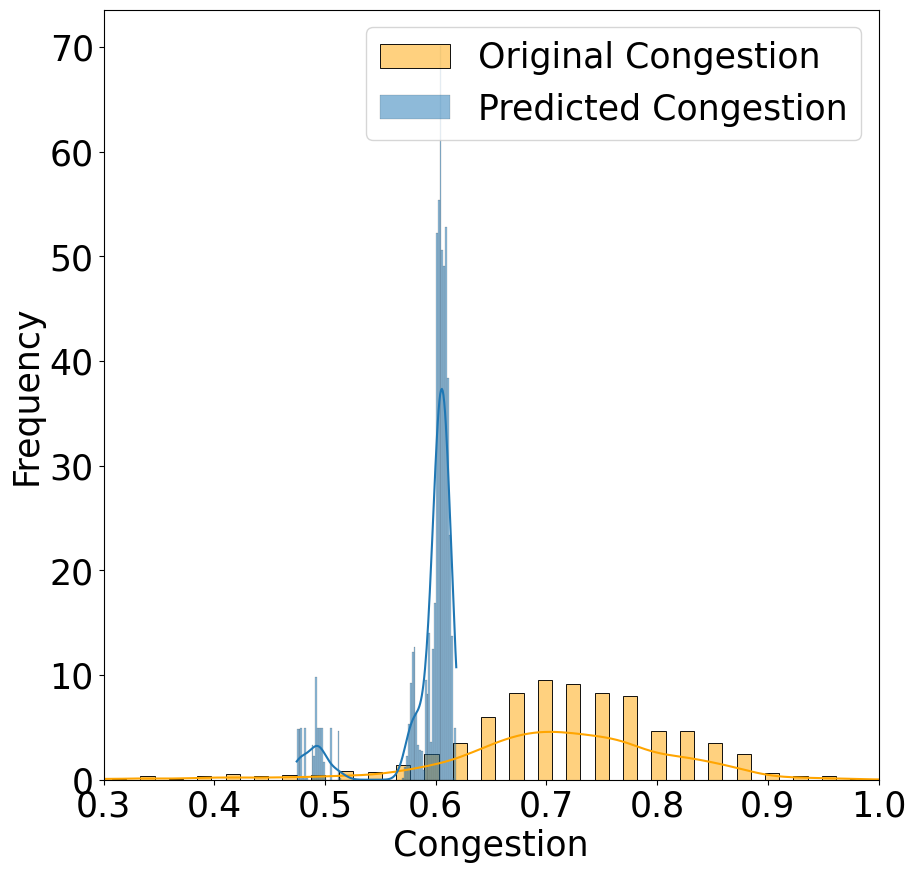

In [244]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(gat_predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

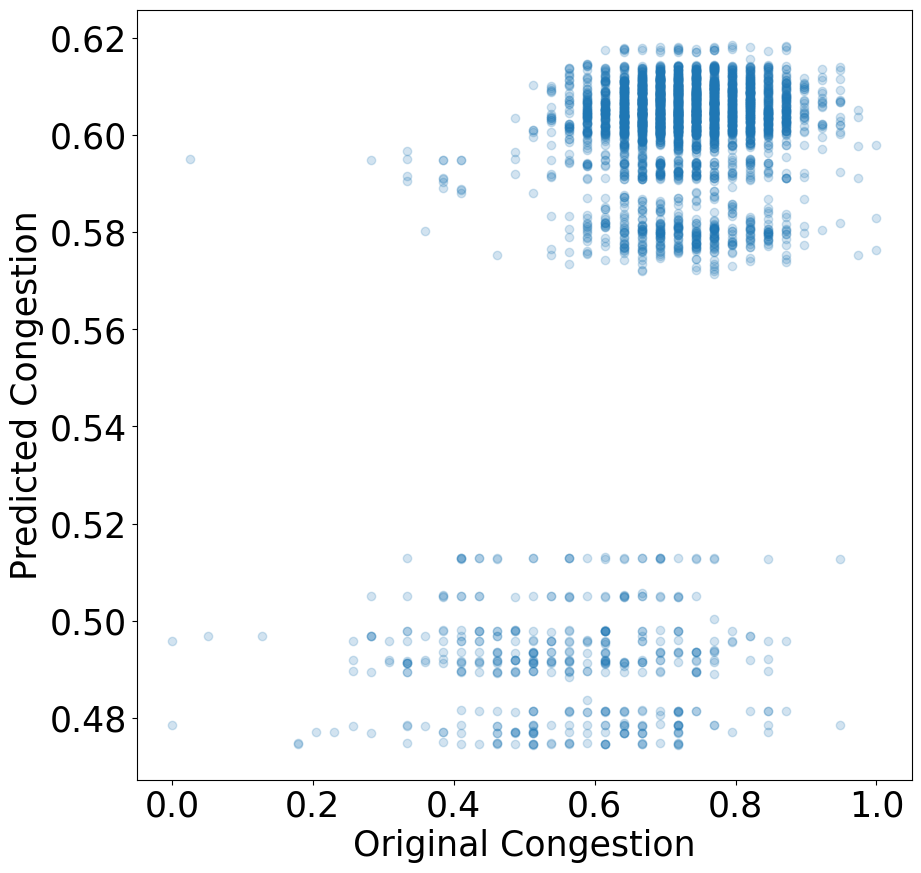

In [245]:
plt.figure(figsize=(10, 10))
plt.scatter(data[0].y.cpu().detach().numpy(), gat_predictions[0], alpha=0.2)
plt.xlabel('Original Congestion', fontsize=25)
plt.ylabel('Predicted Congestion', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [167]:
gat_inversed = congestion_scaler.inverse_transform(gat_predictions[0])
gat_mse = mean_squared_error(instance_lst[0][['congestion']].values, gat_inversed)
gat_mse

34.64604090976453

In [243]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
gat_true_values = data[0].y.cpu().detach().numpy()  # Replace with actual reference to your true congestion values
gat_predicted_values = np.array(gat_predictions[0].flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
gat_correlation_matrix = np.corrcoef(gat_true_values, gat_predicted_values)
gat_correlation_coefficient = gat_correlation_matrix[0, 1]

# Coefficient of determination, R^2
gat_coefficient_of_determination = np.square(gat_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {gat_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {gat_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): 0.4626567272988639
Coefficient of Determination (R²): 0.21405124731489533


---
# GAT four layers (single file)

In [300]:
gat1_data = data[0]
gat1_data

Data(x=[3952, 8], edge_index=[2, 282944], y=[3952], train_mask=[3952], val_mask=[3952], test_mask=[3952])

In [301]:
num_nodes = 3952  # Or set this to the number of nodes in your graph
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
gat1_data.train_mask = train_mask
gat1_data.val_mask = val_mask
gat1_data.test_mask = test_mask

In [302]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted to match DeeperGAT class
gat1_model = DeeperGAT(
    in_channels=8, 
    hidden_channels_1=16, 
    hidden_channels_2=16, 
    hidden_channels_3=16, 
    out_channels=1, 
    heads_1=4, 
    heads_2=4, 
    heads_3=4, 
    heads_4=1,  # Typically, you might not use multiple heads in the final layer
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(gat1_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed


gat1_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    
    # Forward pass: Use the entire graph but compute loss only for the training nodes
    out = gat1_model(gat1_data)
    loss = F.mse_loss(out[gat1_data.train_mask], gat1_data.y[gat1_data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Optional: Evaluation phase
    gat1_model.eval()
    with torch.no_grad():
        # Forward pass: Use the entire graph but evaluate only on the validation nodes
        val_out = gat1_model(gat1_data)
        val_loss = F.mse_loss(val_out[gat1_data.val_mask], gat1_data.y[gat1_data.val_mask])
    
    scheduler.step()  # Adjust learning rate if necessary
    
    print(f'Epoch {epoch+1}: Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1576918485.py:27: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[gat1_data.train_mask], gat1_data.y[gat1_data.train_mask])
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1576918485.py:36: UserWarning: Using a target size (torch.Size([395])) that is different to the input size (torch.Size([395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(val_out[gat1_data.val_mask], gat1_data.y[gat1_data.val_mask])


Epoch 1: Training Loss: 0.6721192002296448, Validation Loss: 0.02032800205051899
Epoch 2: Training Loss: 0.021977277472615242, Validation Loss: 0.278542697429657
Epoch 3: Training Loss: 0.2682386040687561, Validation Loss: 0.20679089426994324
Epoch 4: Training Loss: 0.19738654792308807, Validation Loss: 0.04520227387547493
Epoch 5: Training Loss: 0.04149365425109863, Validation Loss: 0.022455202415585518
Epoch 6: Training Loss: 0.02526899054646492, Validation Loss: 0.08679861575365067
Epoch 7: Training Loss: 0.09425906091928482, Validation Loss: 0.11797413229942322
Epoch 8: Training Loss: 0.12690962851047516, Validation Loss: 0.0923709124326706
Epoch 9: Training Loss: 0.10019704699516296, Validation Loss: 0.0463196262717247
Epoch 10: Training Loss: 0.05145415663719177, Validation Loss: 0.015794435515999794
Epoch 11: Training Loss: 0.017528723925352097, Validation Loss: 0.015368704684078693
Epoch 12: Training Loss: 0.01373586617410183, Validation Loss: 0.03603797033429146
Epoch 13: Trai

In [303]:
def gat1_eval(model, data, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        data = data.to(device)
        # Ensure targets are on the same device as the model output
        targets = data.y.to(device)
        out = model(data)
        # Apply the test mask to focus evaluation on the test set
        test_mask = data.test_mask
        loss = F.mse_loss(out[test_mask], targets[test_mask].view_as(out[test_mask]))  # Ensure shape compatibility
        total_loss = loss.item()
        # Store predictions for test nodes
        predictions = out[test_mask].cpu().detach().numpy()
    return total_loss, predictions

# Assuming gat1_model is your model and gat1_data is your single data object
gat1_test_loss, gat1_predictions = gat1_eval(gat1_model, gat1_data, device)
print(f'Test Loss: {gat1_test_loss}')


Test Loss: 0.008837095461785793


In [304]:
len(gat1_predictions)

396

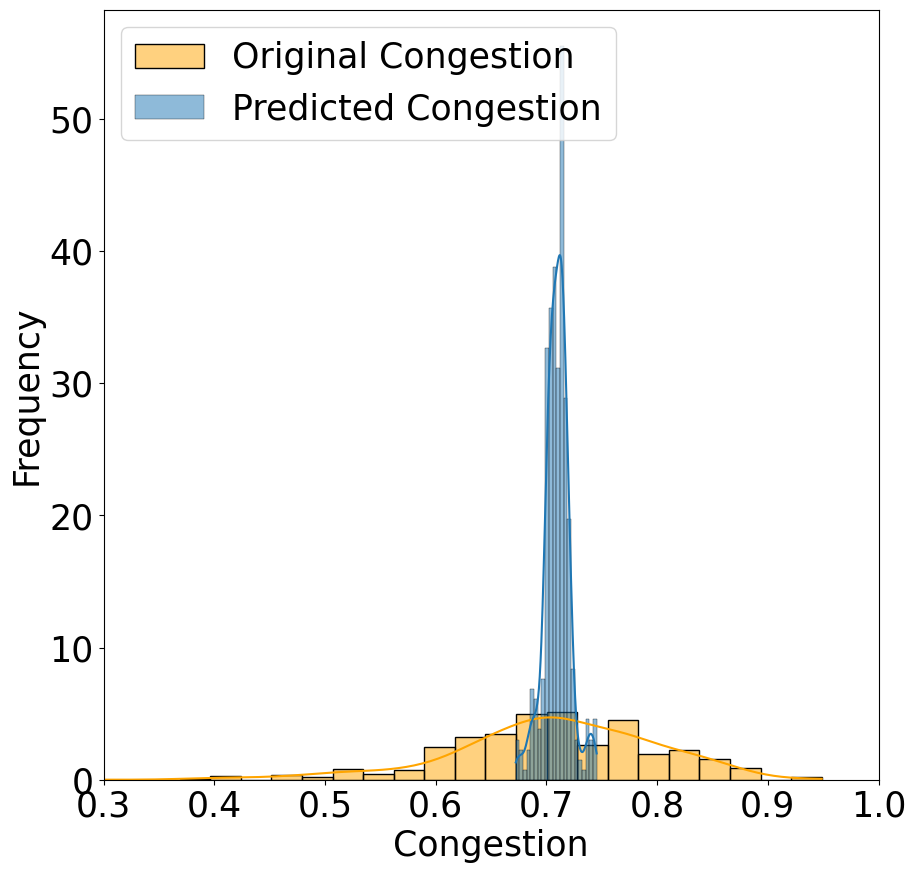

In [305]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y[gat1_data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(gat1_predictions, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25, loc="upper left")
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

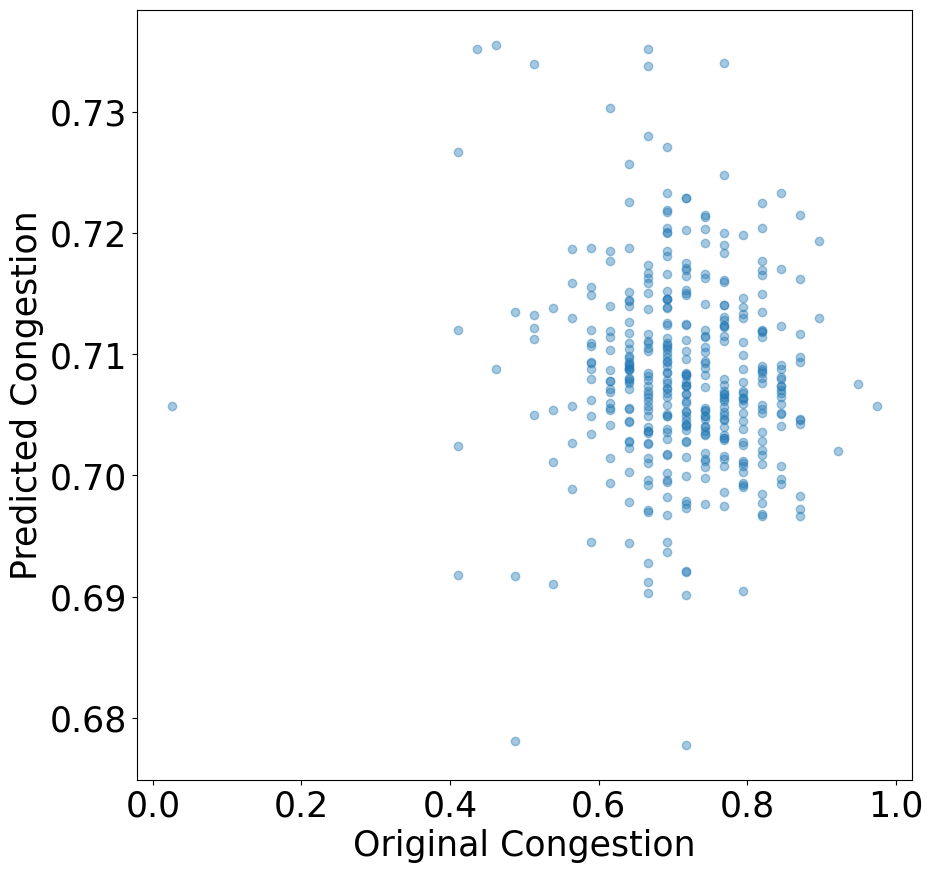

In [251]:
plt.figure(figsize=(10, 10))
plt.scatter(data[0].y[gat1_data.test_mask].cpu().detach().numpy(), gat1_predictions, alpha=0.4)
plt.xlabel('Original Congestion', fontsize=25)
plt.ylabel('Predicted Congestion', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [257]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
gat1_true_values = data[0].y[gat1_data.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
gat1_predicted_values = np.array(gat1_predictions.flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
gat1_correlation_matrix = np.corrcoef(gat1_true_values, gat1_predicted_values)
gat1_correlation_coefficient = gat1_correlation_matrix[0, 1]

# Coefficient of determination, R^2
gat1_coefficient_of_determination = np.square(gat1_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {gat1_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {gat1_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): -0.06901814189009127
Coefficient of Determination (R²): 0.004763503909960771


---
# GAT 2 layers

In [270]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.6):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

In [271]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [295]:
gat_base_data = data[0]
gat_base_data

Data(x=[3952, 8], edge_index=[2, 282944], y=[3952], train_mask=[3952], val_mask=[3952], test_mask=[3952])

In [296]:
num_nodes = 3952  # Or set this to the number of nodes in your graph
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
gat_base_data.train_mask = train_mask
gat_base_data.val_mask = val_mask
gat_base_data.test_mask = test_mask

In [274]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gat_base_model = GAT(in_channels=8, hidden_channels=8, out_channels=1, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(gat_base_model.parameters(), lr=0.005, weight_decay=5e-4)

loss_values = []

gat_base_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = gat_base_model(gat_base_data)
    loss = F.mse_loss(out[gat_base_data.train_mask], gat_base_data.y[gat_base_data.train_mask])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1452725730.py:11: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[gat_base_data.train_mask], gat_base_data.y[gat_base_data.train_mask])


Epoch 1, Loss: 0.6618922352790833
Epoch 2, Loss: 0.46482422947883606
Epoch 3, Loss: 0.3149975836277008
Epoch 4, Loss: 0.20295661687850952
Epoch 5, Loss: 0.14620617032051086
Epoch 6, Loss: 0.11496987193822861
Epoch 7, Loss: 0.11238306015729904
Epoch 8, Loss: 0.12299365550279617
Epoch 9, Loss: 0.1744535267353058
Epoch 10, Loss: 0.1993890106678009
Epoch 11, Loss: 0.18378028273582458
Epoch 12, Loss: 0.1596418172121048
Epoch 13, Loss: 0.1545337736606598
Epoch 14, Loss: 0.15374630689620972
Epoch 15, Loss: 0.13588710129261017
Epoch 16, Loss: 0.09957065433263779
Epoch 17, Loss: 0.09493646770715714
Epoch 18, Loss: 0.08940504491329193
Epoch 19, Loss: 0.09700042009353638
Epoch 20, Loss: 0.09490030258893967
Epoch 21, Loss: 0.09565488249063492
Epoch 22, Loss: 0.10845910012722015
Epoch 23, Loss: 0.11302658915519714
Epoch 24, Loss: 0.10598192363977432
Epoch 25, Loss: 0.10524605214595795
Epoch 26, Loss: 0.10310065746307373
Epoch 27, Loss: 0.10293800383806229
Epoch 28, Loss: 0.09044037759304047
Epoch 2

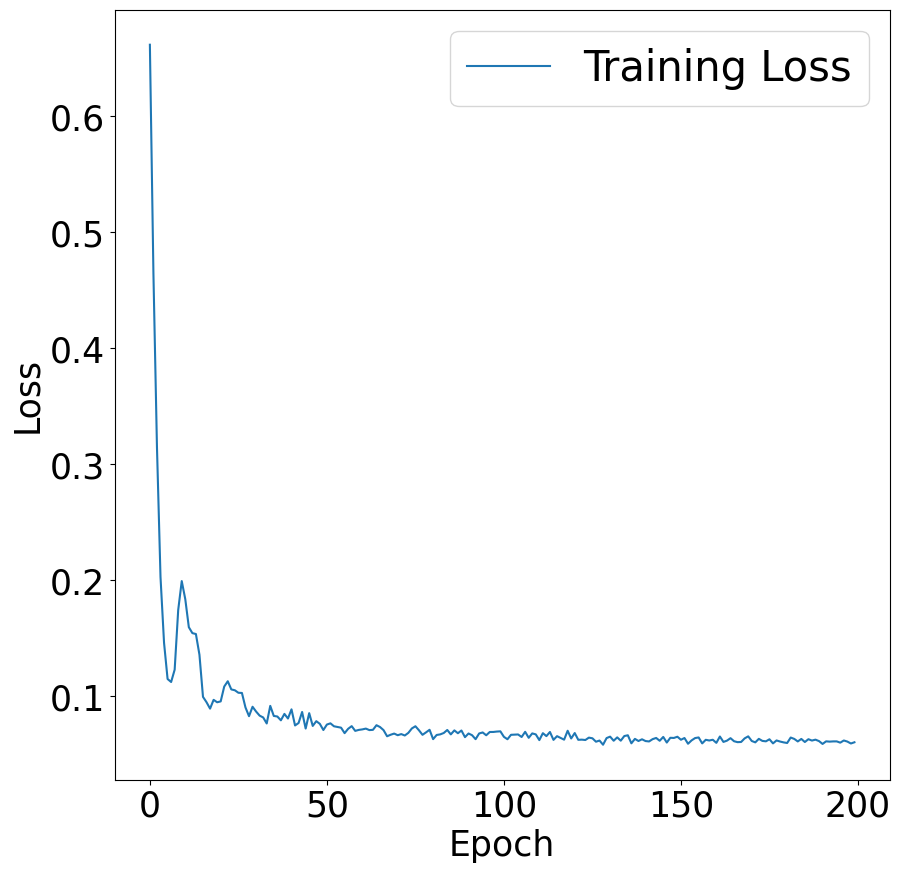

In [284]:
plt.figure(figsize=(10, 10))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Loss', fontsize=25)
# plt.title('Training Loss Over Epochs')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.legend(fontsize=30, loc="upper right")
plt.show()


In [285]:
# Evaluate the model
gat_base_model.eval()
gat_base_out = gat_base_model(gat_base_data)
loss = F.mse_loss(gat_base_out[gat_base_data.test_mask], gat_base_data.y[gat_base_data.test_mask])
print(f'Test Loss: {loss.item()}')

Test Loss: 0.01763991080224514


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1242619792.py:4: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(gat_base_out[gat_base_data.test_mask], gat_base_data.y[gat_base_data.test_mask])


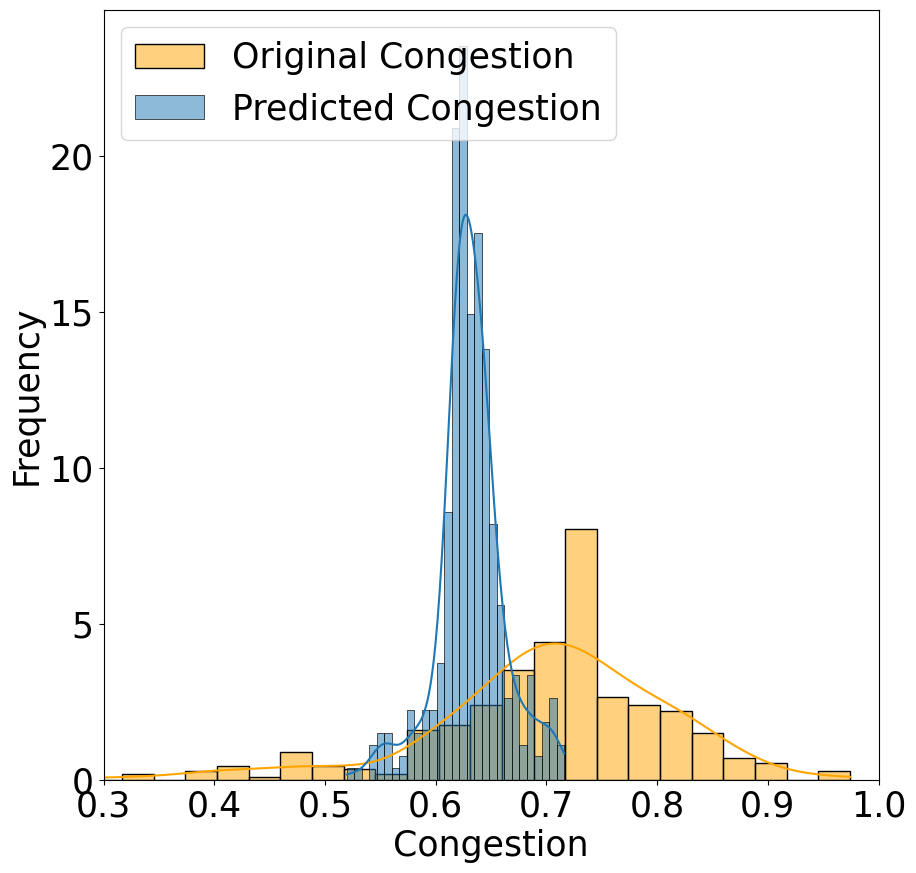

In [286]:
# plot the distribution of original congestion and predicted congestion
plt.figure(figsize=(10, 10))
sns.histplot(gat_base_data.y[gat_base_data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(gat_base_out[gat_base_data.test_mask].cpu().detach().numpy(), kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25, loc="upper left")
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()


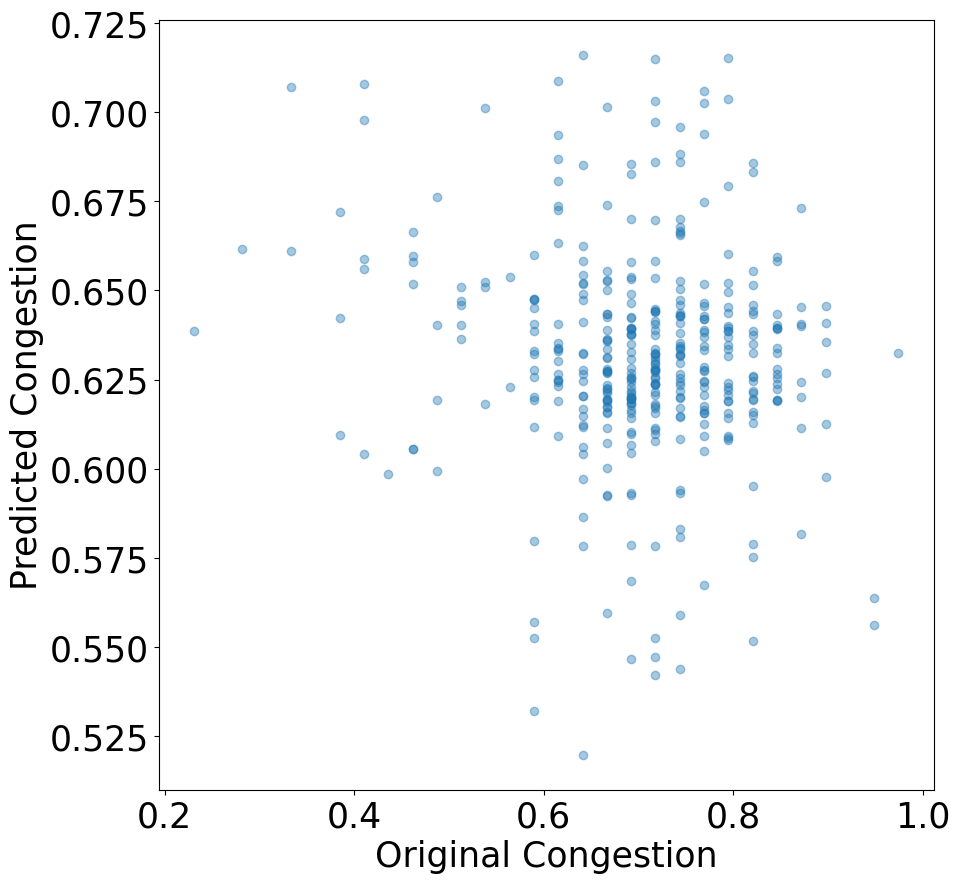

In [292]:
plt.figure(figsize=(10, 10))
plt.scatter(gat_base_data.y[gat_base_data.test_mask].cpu().detach().numpy(), gat_base_out[gat_base_data.test_mask].cpu().detach().numpy().flatten(), alpha=0.4)
plt.xlabel('Original Congestion', fontsize=25)
plt.ylabel('Predicted Congestion', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [293]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
gatbase_true_values = gat_base_data.y[gat_base_data.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
gatbase_predicted_values = np.array(gat_base_out[gat_base_data.test_mask].cpu().detach().numpy().flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
gatbase_correlation_matrix = np.corrcoef(gatbase_true_values, gatbase_predicted_values)
gatbase_correlation_coefficient = gatbase_correlation_matrix[0, 1]

# Coefficient of determination, R^2
gatbase_coefficient_of_determination = np.square(gatbase_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {gatbase_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {gatbase_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): -0.12794510822479133
Coefficient of Determination (R²): 0.016369950718653565


In [294]:
gat_base_out[gat_base_data.test_mask].cpu().detach().numpy()

array([[0.65187675],
       [0.63871527],
       [0.64024574],
       [0.6401816 ],
       [0.6256669 ],
       [0.6517484 ],
       [0.6459777 ],
       [0.6511012 ],
       [0.69370055],
       [0.6959382 ],
       [0.6976791 ],
       [0.6664646 ],
       [0.6696692 ],
       [0.6761078 ],
       [0.66661537],
       [0.6719405 ],
       [0.673793  ],
       [0.6724469 ],
       [0.65964687],
       [0.6524407 ],
       [0.6580303 ],
       [0.64215434],
       [0.6476906 ],
       [0.64731294],
       [0.64713687],
       [0.6616322 ],
       [0.59858936],
       [0.6056306 ],
       [0.59944624],
       [0.60403246],
       [0.60919327],
       [0.6081104 ],
       [0.6056686 ],
       [0.70104337],
       [0.708765  ],
       [0.7069598 ],
       [0.7077569 ],
       [0.7059389 ],
       [0.66112024],
       [0.65305614],
       [0.65599376],
       [0.6581756 ],
       [0.662361  ],
       [0.6598861 ],
       [0.6586955 ],
       [0.68250567],
       [0.68068635],
       [0.686

In [ ]:
# Setting a larger figure size
plt.figure(figsize=(15, 15))

# Define the range of congestion values (-10 to 10)
min_congestion = -10
max_congestion = 10

# Normalize the congestion values between 0 and 1
norm = mcolors.Normalize(vmin=min_congestion, vmax=max_congestion)

# Get the 'Spectral' colormap
cmap = plt.cm.get_cmap('Spectral')
reversed_map = cmap.reversed()  # reversing the original colormap using reversed() function

# Create plot for Layer 1
plt.figure(figsize=(8, 6))
plt.imshow(congestion[1], cmap=reversed_map, norm=norm, interpolation='nearest')
colorbar = plt.colorbar(label='Congestions')
colorbar.set_label('Congestions', fontsize=18)
# Adjust font size for colorbar tick labels
colorbar.ax.tick_params(labelsize=18)
                        
plt.xlabel('X Location', fontsize=18)
plt.ylabel('Y Location', fontsize=18)
lay = congestion_data['layerList'][1]
# plt.title(f'VLSI Demand Heatmap - Layer {lay}')

# Adjust font size for x-axis and y-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [298]:
data[0].x

tensor([[0.4962, 0.5000, 0.5185,  ..., 0.0000, 0.0000, 0.0000],
        [0.4962, 0.5357, 0.5185,  ..., 0.0000, 0.0000, 1.0000],
        [0.5222, 0.5000, 0.5185,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2726, 0.7500, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4793, 0.5000, 0.0741,  ..., 0.0000, 0.0000, 0.0000],
        [0.5544, 0.5000, 0.0741,  ..., 0.0000, 0.0000, 1.0000]])

---
# Test from here

In [369]:
conn=np.load(data_path + 'xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

In [370]:
import numpy as np
from scipy.sparse import coo_matrix

# Assuming A is your adjacency matrix in COO format

# Convert COO matrix to CSR format for faster row-wise operations
A_csr = A.tocsr()

# Count the number of non-zero entries in each row (which corresponds to the degree)
# and subtract 1 if there's a self-loop
degree_of_each_node = np.diff(A_csr.indptr) - (A_csr.diagonal() != 0)
degree_of_each_node

array([46, 46, 46, ..., 76, 25, 13], dtype=int32)

In [371]:
instances, A = instances_ini(1)
cells = cell_ini(1)
new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
new_instances


,name,id_x,xloc,yloc,cell,orient,routing_demand,routing_capacity,congestion,id_y,width,height
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0,23,2176,1536
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0,23,2176,1536
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0,23,2176,1536
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0,23,2176,1536
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0,23,2176,1536
...,...,...,...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0,42,512,1536
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0,42,512,1536
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0,34,384,1536
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0,11,640,1536


In [372]:
def test_norm_ohe(new_instances):
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()
    scaler = MinMaxScaler()
    new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'degrees']])
    #test for non transforming
    # new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']]
    return new_instances, orient

In [373]:
picked_instances = new_instances[['xloc', 'yloc', 'congestion', 'width','orient']]
picked_instances['degrees'] = degree_of_each_node
picked_instances

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/3251703127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picked_instances['degrees'] = degree_of_each_node


,xloc,yloc,congestion,width,orient,degrees
0,41984,44544,-8.0,2176,0,46
1,41984,47616,-5.0,2176,6,46
2,44160,44544,-10.0,2176,0,46
3,44160,47616,-11.0,2176,0,46
4,46336,47616,-2.0,2176,0,46
...,...,...,...,...,...,...
3947,21888,53760,0.0,512,4,68
3948,33664,66048,0.0,512,0,68
3949,23296,66048,-2.0,384,0,76
3950,40576,44544,-5.0,640,0,25


In [374]:
normed_instances, orient = test_norm_ohe(picked_instances)
normed_instances

array([[0.49617152, 0.5       , 0.69230769, 0.51851852, 0.59459459],
       [0.49617152, 0.53571429, 0.76923077, 0.51851852, 0.59459459],
       [0.52220521, 0.5       , 0.64102564, 0.51851852, 0.59459459],
       ...,
       [0.27258806, 0.75      , 0.84615385, 0.        , 1.        ],
       [0.47932619, 0.5       , 0.76923077, 0.07407407, 0.31081081],
       [0.55436447, 0.5       , 0.56410256, 0.07407407, 0.14864865]])

In [375]:
y = normed_instances[:,2]
# remove congestion from new_instances
node_features = np.delete(normed_instances, 2, 1)
node_features = np.concatenate((node_features, orient), axis=1)
source_nodes, target_nodes = np.nonzero(A)
edge_index = np.vstack((source_nodes, target_nodes))
edge_index = torch.tensor(edge_index, dtype=torch.long)

# reverse_edge_index = torch.stack((edge_index[1], edge_index[0]), dim=0)  # Flip each edge
# bidirectional_edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)

x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
test_data = Data(x=x, edge_index=edge_index, y=y)

In [376]:
num_nodes = 3952  
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
test_data.train_mask = train_mask
test_data.val_mask = val_mask
test_data.test_mask = test_mask

In [378]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GCN model
test_model = GCN(
    in_channels=8, 
    hidden_channels=64, 
    out_channels=1, 
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(test_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

gcn_single.to(device)


for epoch in range(700):
    test_model.train()
    optimizer.zero_grad()
    
    test_out = test_model(test_data)  # Assuming your model's forward pass can handle the entire graph
    loss = F.mse_loss(test_out[test_data.train_mask], test_data.y[test_data.train_mask].to(device))
    loss.backward()
    optimizer.step()

    scheduler.step()
    
    # Validation phase
    test_model.eval()
    with torch.no_grad():
        test_val_out = test_model(test_data)
        val_loss = F.mse_loss(test_val_out[test_data.val_mask], test_data.y[test_data.val_mask].to(device))
        # Calculate validation metrics as needed
    
    # Print or log your training and validation loss
    print(f'Epoch {epoch+1}: Training Loss {loss.item()}, Validation Loss {val_loss.item()}')


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1317036536.py:22: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(test_out[test_data.train_mask], test_data.y[test_data.train_mask].to(device))
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1317036536.py:32: UserWarning: Using a target size (torch.Size([395])) that is different to the input size (torch.Size([395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(test_val_out[test_data.val_mask], test_data.y[test_data.val_mask].to(device))


Epoch 1: Training Loss 0.7166061401367188, Validation Loss 0.33068761229515076
Epoch 2: Training Loss 0.33326101303100586, Validation Loss 0.14206980168819427
Epoch 3: Training Loss 0.12985610961914062, Validation Loss 0.06427019834518433
Epoch 4: Training Loss 0.057555750012397766, Validation Loss 0.09572625160217285
Epoch 5: Training Loss 0.09324449300765991, Validation Loss 0.12580078840255737
Epoch 6: Training Loss 0.12410023808479309, Validation Loss 0.10842420905828476
Epoch 7: Training Loss 0.10538985580205917, Validation Loss 0.07873360812664032
Epoch 8: Training Loss 0.0749313086271286, Validation Loss 0.06138250231742859
Epoch 9: Training Loss 0.05757677182555199, Validation Loss 0.058641448616981506
Epoch 10: Training Loss 0.052391838282346725, Validation Loss 0.06410948932170868
Epoch 11: Training Loss 0.05567294731736183, Validation Loss 0.07088667899370193
Epoch 12: Training Loss 0.06079072505235672, Validation Loss 0.07411154359579086
Epoch 13: Training Loss 0.0645755380

In [379]:
test_model.eval()

with torch.no_grad():
    # Get model predictions. Here, make sure to use your actual model variable and data object
    test_out = test_model(test_data)
    # Calculate the Mean Squared Error (MSE) loss on the test set
    # Adjust this line to match your data object's actual test mask and labels
    test_loss = F.mse_loss(test_out[test_data.test_mask], test_data.y[test_data.test_mask])
    # Print the test loss
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 0.01973051019012928


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/4256246944.py:8: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_out[test_data.test_mask], test_data.y[test_data.test_mask])


In [380]:
test_pred = test_out[test_data.test_mask].detach().cpu().numpy()

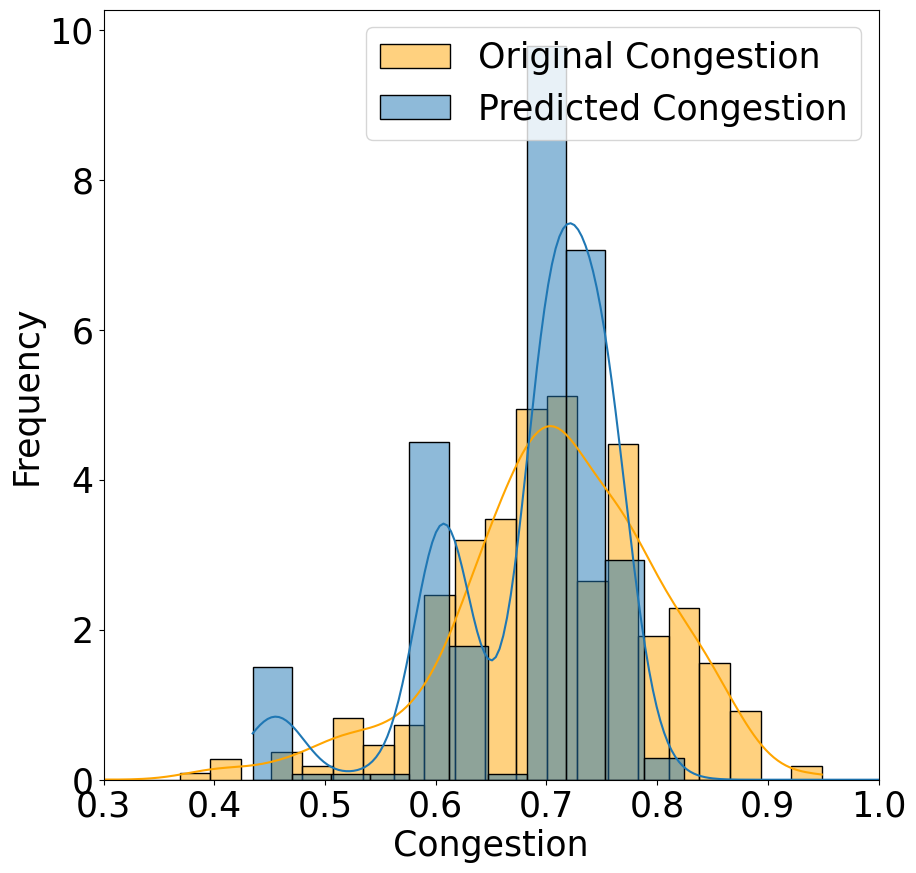

In [381]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y[gcn_single.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(test_pred, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [382]:
test_inversed = congestion_scaler.inverse_transform(test_pred)
test_mse = mean_squared_error(instance_lst[0][['congestion']].values[test_data.test_mask], test_inversed)
test_mse

29.976912627661143

In [383]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
test_true_values = data[0].y[gcn_single.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
test_predicted_values = np.array(test_pred.flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
test_correlation_matrix = np.corrcoef(test_true_values, test_predicted_values)
test_correlation_coefficient = test_correlation_matrix[0, 1]

# Coefficient of determination, R^2
test_coefficient_of_determination = np.square(test_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {test_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {test_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): 0.012030198602885006
Coefficient of Determination (R²): 0.00014472567842485637


---
# test for gat

In [384]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted to match DeeperGAT class
test_gat_model = DeeperGAT(
    in_channels=8, 
    hidden_channels_1=32, 
    hidden_channels_2=32, 
    hidden_channels_3=32, 
    out_channels=1, 
    heads_1=4, 
    heads_2=4, 
    heads_3=4, 
    heads_4=1,  # Typically, you might not use multiple heads in the final layer
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(test_gat_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed


test_gat_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    # Forward pass: Use the entire graph but compute loss only for the training nodes
    out = test_gat_model(test_data)
    loss = F.mse_loss(out[test_data.train_mask], test_data.y[test_data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Optional: Evaluation phase
    test_gat_model.eval()
    with torch.no_grad():
        # Forward pass: Use the entire graph but evaluate only on the validation nodes
        val_out = test_gat_model(test_data)
        val_loss = F.mse_loss(val_out[test_data.val_mask], test_data.y[test_data.val_mask])
    
    scheduler.step()  # Adjust learning rate if necessary
    
    print(f'Epoch {epoch+1}: Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1740355127.py:26: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[test_data.train_mask], test_data.y[test_data.train_mask])
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1740355127.py:35: UserWarning: Using a target size (torch.Size([395])) that is different to the input size (torch.Size([395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(val_out[test_data.val_mask], test_data.y[test_data.val_mask])


Epoch 1: Training Loss: 0.36249521374702454, Validation Loss: 1.5238173007965088
Epoch 2: Training Loss: 1.5289193391799927, Validation Loss: 0.08458835631608963
Epoch 3: Training Loss: 0.08603305369615555, Validation Loss: 0.31262508034706116
Epoch 4: Training Loss: 0.30991271138191223, Validation Loss: 0.45948556065559387
Epoch 5: Training Loss: 0.45492714643478394, Validation Loss: 0.21388912200927734
Epoch 6: Training Loss: 0.21027572453022003, Validation Loss: 0.033590491861104965
Epoch 7: Training Loss: 0.03238646686077118, Validation Loss: 0.027476809918880463
Epoch 8: Training Loss: 0.02895337902009487, Validation Loss: 0.0987280011177063
Epoch 9: Training Loss: 0.10191867500543594, Validation Loss: 0.10136368125677109
Epoch 10: Training Loss: 0.10445094853639603, Validation Loss: 0.04097452759742737
Epoch 11: Training Loss: 0.042709603905677795, Validation Loss: 0.011271677911281586
Epoch 12: Training Loss: 0.011354447342455387, Validation Loss: 0.045902740210294724
Epoch 13: 

In [386]:
def test_gat_eval(model, data, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        data = data.to(device)
        # Ensure targets are on the same device as the model output
        targets = data.y.to(device)
        out = model(data)
        # Apply the test mask to focus evaluation on the test set
        test_mask = data.test_mask
        loss = F.mse_loss(out[test_mask], targets[test_mask].view_as(out[test_mask]))  # Ensure shape compatibility
        total_loss = loss.item()
        # Store predictions for test nodes
        predictions = out[test_mask].cpu().detach().numpy()
    return total_loss, predictions

# Assuming gat1_model is your model and gat1_data is your single data object
test_gat_test_loss, test_gat_predictions = test_gat_eval(test_gat_model, test_data, device)
print(f'Test Loss: {test_gat_test_loss}')


Test Loss: 0.012671203352510929


In [388]:
len(test_gat_predictions)

396

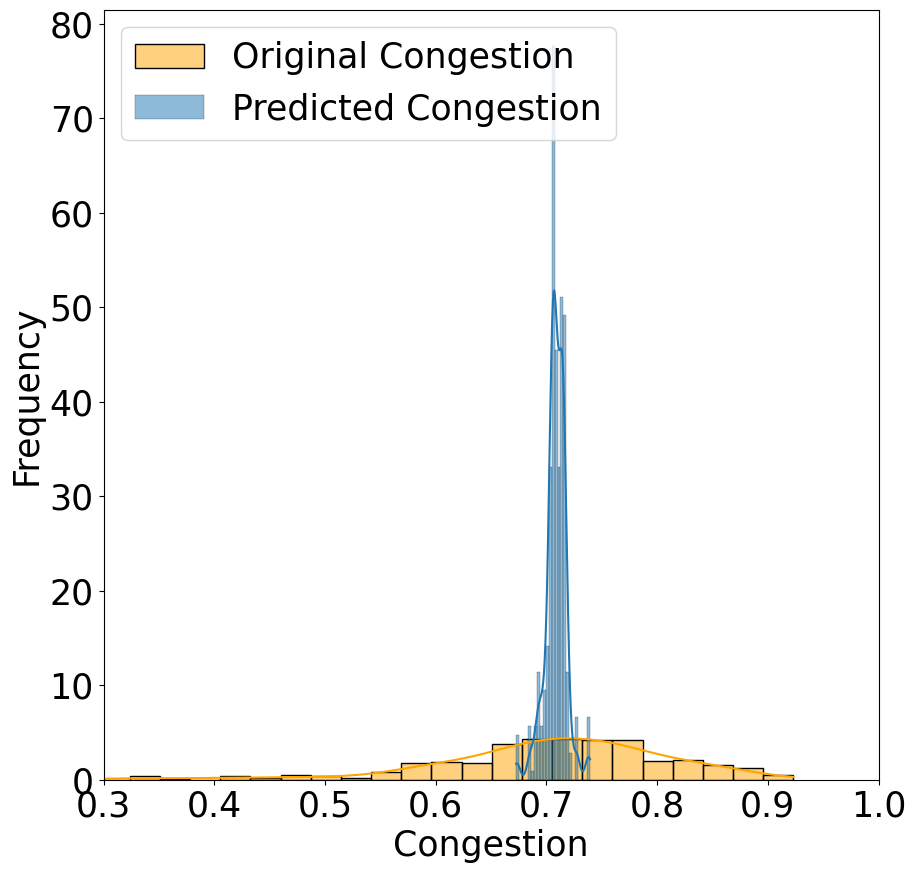

In [389]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y[test_data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(test_gat_predictions, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25, loc="upper left")
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [391]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
tgat_true_values = data[0].y[test_data.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
tgat_predicted_values = np.array(test_gat_predictions.flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
tgat_correlation_matrix = np.corrcoef(tgat_true_values, tgat_predicted_values)
tgat_correlation_coefficient = tgat_correlation_matrix[0, 1]

# Coefficient of determination, R^2
tgat_coefficient_of_determination = np.square(tgat_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {tgat_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {tgat_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): -0.02845043937555038
Coefficient of Determination (R²): 0.0008094275006618675


In [394]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tgat2_model = GAT(in_channels=8, hidden_channels=8, out_channels=1, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(tgat2_model.parameters(), lr=0.005, weight_decay=5e-4)

loss_values = []

tgat2_model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = tgat2_model(test_data)
    loss = F.mse_loss(out[test_data.train_mask], test_data.y[test_data.train_mask])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/968284250.py:11: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[test_data.train_mask], test_data.y[test_data.train_mask])


Epoch 1, Loss: 0.2781229615211487
Epoch 2, Loss: 0.15483710169792175
Epoch 3, Loss: 0.12896370887756348
Epoch 4, Loss: 0.15299417078495026
Epoch 5, Loss: 0.21003951132297516
Epoch 6, Loss: 0.19930586218833923
Epoch 7, Loss: 0.12626148760318756
Epoch 8, Loss: 0.1397293210029602
Epoch 9, Loss: 0.10829976946115494
Epoch 10, Loss: 0.1020687147974968
Epoch 11, Loss: 0.11558849364519119
Epoch 12, Loss: 0.11272857338190079
Epoch 13, Loss: 0.11487319320440292
Epoch 14, Loss: 0.11178504675626755
Epoch 15, Loss: 0.12302703410387039
Epoch 16, Loss: 0.09740336239337921
Epoch 17, Loss: 0.09213010966777802
Epoch 18, Loss: 0.1051715686917305
Epoch 19, Loss: 0.09654871374368668
Epoch 20, Loss: 0.10067495703697205
Epoch 21, Loss: 0.09004022926092148
Epoch 22, Loss: 0.09618823975324631
Epoch 23, Loss: 0.08886037766933441
Epoch 24, Loss: 0.08525805175304413
Epoch 25, Loss: 0.08403918892145157
Epoch 26, Loss: 0.07780695706605911
Epoch 27, Loss: 0.0844758078455925
Epoch 28, Loss: 0.0805445984005928
Epoch 2

In [395]:
# Evaluate the model
tgat2_model.eval()
tgat2_out = tgat2_model(test_data)
loss = F.mse_loss(tgat2_out[test_data.test_mask], test_data.y[test_data.test_mask])
print(f'Test Loss: {loss.item()}')

Test Loss: 0.018580999225378036


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/4011349121.py:4: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(tgat2_out[test_data.test_mask], test_data.y[test_data.test_mask])


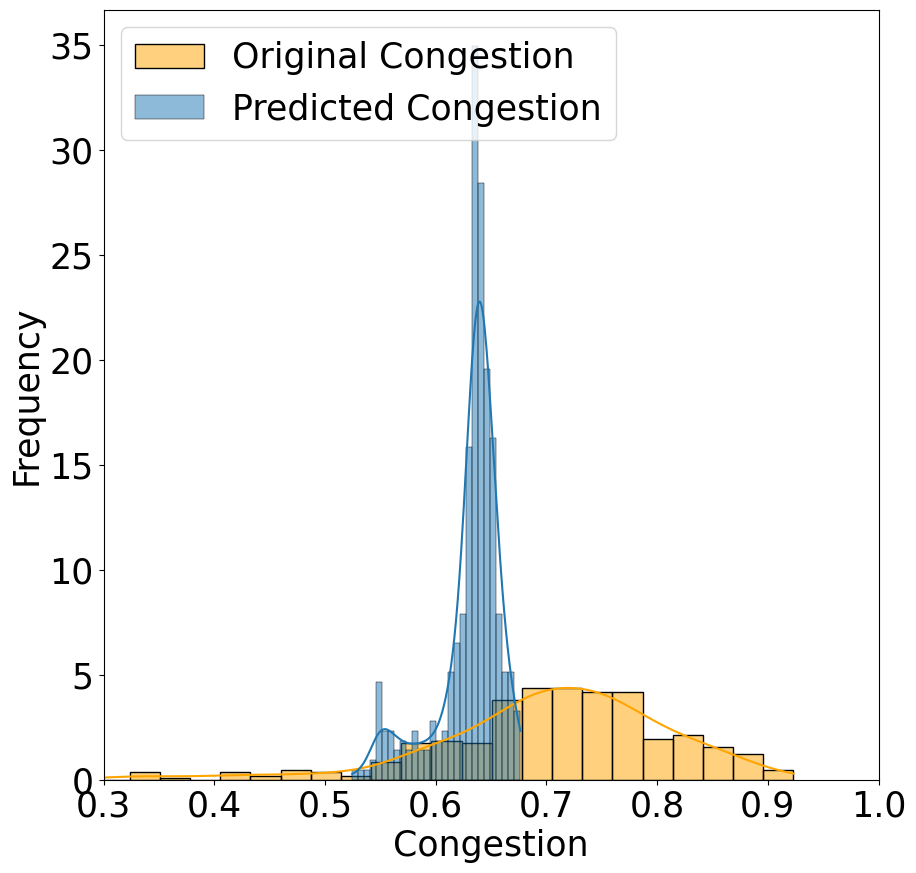

In [396]:
# plot the distribution of original congestion and predicted congestion
plt.figure(figsize=(10, 10))
sns.histplot(test_data.y[test_data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(tgat2_out[test_data.test_mask].cpu().detach().numpy(), kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25, loc="upper left")
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()


In [397]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
tgat2_true_values = test_data.y[test_data.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
tgat2_predicted_values = np.array(tgat2_out[test_data.test_mask].cpu().detach().numpy().flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
tgat2_correlation_matrix = np.corrcoef(tgat2_true_values, tgat2_predicted_values)
tgat2_correlation_coefficient = tgat2_correlation_matrix[0, 1]

# Coefficient of determination, R^2
tgat2_coefficient_of_determination = np.square(tgat2_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {tgat2_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {tgat2_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): 0.0325323682469536
Coefficient of Determination (R²): 0.001058354983755395


---
# Test for in/out degree 

In [490]:
with gzip.open(data_path + 'xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])

In [491]:
with gzip.open(data_path+ 'cells.json.gz','rb') as f:
    cells = json.loads(f.read().decode('utf-8'))

cells = pd.DataFrame(cells)

In [492]:
conn=np.load(data_path + 'xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
adj_A = A.__mul__(A.T)

In [502]:
# Assuming A is your incidence matrix in COO format
# 'instances' is a DataFrame with an 'id' and 'cell' column
# 'cells' is a DataFrame where each row represents a cell, including a 'terms' list of dictionaries

# Initialize net_info with zeros for each net
net_info = {'input_counts': np.zeros(A.shape[1], dtype=int),
            'output_counts': np.zeros(A.shape[1], dtype=int)}

for i, j, term_id in zip(A.row, A.col, A.data):
    cell_id = instances.loc[i, 'cell']
    cell_terms = cells.loc[cell_id, 'terms']  # Assuming 'cell_id' directly maps to the index or a uniquely identifying column in 'cells'
    
    # Find term information by term_id
    term_info = [term for term in cell_terms if term['id'] == term_id][0]  # Extract the first matching term
    dir = term_info['dir']
    
    if dir == 0: 
        net_info['input_counts'][j] += 1
    elif dir == 1:
        net_info['output_counts'][j] += 1
    elif dir == 2:
        net_info['output_counts'][j] += 1
        net_info['input_counts'][j] += 1


In [509]:
# Initialize degree counts
in_degrees = np.zeros(A.shape[0], dtype=int)
out_degrees = np.zeros(A.shape[0], dtype=int)

# Iterate through the incidence matrix again to calculate degrees
for i, j, term_id in zip(A.row, A.col, A.data):
    cell_id = instances.loc[i, 'cell']
    cell_terms = cells.loc[cell_id, 'terms']
    
    # Find term information by term_id
    term_info = [term for term in cell_terms if term['id'] == term_id][0]  # Extract the first matching term
    dir = term_info['dir']
    
    if dir == 0:  # Instance's input terminal
        in_degrees[i] += net_info['output_counts'][j]  # Add outputs from net as inputs to instance
    elif dir == 1:  # Instance's output terminal
        out_degrees[i] += net_info['input_counts'][j]  # Add inputs from net as outputs to instance
    elif dir == 2:
        in_degrees[i] += net_info['output_counts'][j]
        out_degrees[i] += net_info['input_counts'][j]


# Assuming 'instances' is also a pandas DataFrame and 'A' is the dense numpy array from the incidence matrix

In [528]:
def degree_norm_ohe(new_instances):
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()
    scaler = MinMaxScaler()
    new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'in_degrees']])
    #test for non transforming
    # new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']]
    return new_instances, orient

In [529]:
degree_instances = new_instances[['xloc', 'yloc', 'congestion', 'width','orient']]
degree_instances['in_degrees'] = in_degrees
# degree_instances['out_degrees'] = out_degrees
degree_instances

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/1964489479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degree_instances['in_degrees'] = in_degrees


,xloc,yloc,congestion,width,orient,in_degrees
0,41984,44544,-8.0,2176,0,14
1,41984,47616,-5.0,2176,6,14
2,44160,44544,-10.0,2176,0,14
3,44160,47616,-11.0,2176,0,14
4,46336,47616,-2.0,2176,0,14
...,...,...,...,...,...,...
3947,21888,53760,0.0,512,4,37
3948,33664,66048,0.0,512,0,37
3949,23296,66048,-2.0,384,0,42
3950,40576,44544,-5.0,640,0,13


In [530]:
degree_normed_instances, orient = degree_norm_ohe(degree_instances)
degree_normed_instances

array([[0.49617152, 0.5       , 0.69230769, 0.51851852, 0.14942529],
       [0.49617152, 0.53571429, 0.76923077, 0.51851852, 0.14942529],
       [0.52220521, 0.5       , 0.64102564, 0.51851852, 0.14942529],
       ...,
       [0.27258806, 0.75      , 0.84615385, 0.        , 0.47126437],
       [0.47932619, 0.5       , 0.76923077, 0.07407407, 0.13793103],
       [0.55436447, 0.5       , 0.56410256, 0.07407407, 0.        ]])

In [537]:
y = degree_normed_instances[:,2]
# remove congestion from new_instances
node_features = np.delete(degree_normed_instances, 2, 1)
node_features = np.concatenate((node_features, orient), axis=1)
source_nodes, target_nodes = np.nonzero(adj_A)
edge_index = np.vstack((source_nodes, target_nodes))
edge_index = torch.tensor(edge_index, dtype=torch.long)

# reverse_edge_index = torch.stack((edge_index[1], edge_index[0]), dim=0)  # Flip each edge
# bidirectional_edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)

x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
degree_data = Data(x=x, edge_index=edge_index, y=y)

In [538]:
num_nodes = 3952  
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
degree_data.train_mask = train_mask
degree_data.val_mask = val_mask
degree_data.test_mask = test_mask

In [539]:
degree_data

Data(x=[3952, 8], edge_index=[2, 141472], y=[3952], train_mask=[3952], val_mask=[3952], test_mask=[3952])

In [540]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GCN model
gcn_degree_model = GCN(
    in_channels=8, 
    hidden_channels=64, 
    out_channels=1, 
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(gcn_degree_model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

degree_data.to(device)


for epoch in range(700):
    gcn_degree_model.train()
    optimizer.zero_grad()
    
    degree_out = gcn_degree_model(degree_data)  # Assuming your model's forward pass can handle the entire graph
    loss = F.mse_loss(degree_out[degree_data.train_mask], degree_data.y[degree_data.train_mask].to(device))
    loss.backward()
    optimizer.step()

    scheduler.step()
    
    # Validation phase
    gcn_degree_model.eval()
    with torch.no_grad():
        degree_val_out = gcn_degree_model(degree_data)
        val_loss = F.mse_loss(degree_val_out[degree_data.val_mask], degree_data.y[degree_data.val_mask].to(device))
        # Calculate validation metrics as needed
    
    # Print or log your training and validation loss
    print(f'Epoch {epoch+1}: Training Loss {loss.item()}, Validation Loss {val_loss.item()}')


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/3956960902.py:22: UserWarning: Using a target size (torch.Size([3161])) that is different to the input size (torch.Size([3161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(degree_out[degree_data.train_mask], degree_data.y[degree_data.train_mask].to(device))
/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/3956960902.py:32: UserWarning: Using a target size (torch.Size([395])) that is different to the input size (torch.Size([395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(degree_val_out[degree_data.val_mask], degree_data.y[degree_data.val_mask].to(device))


Epoch 1: Training Loss 0.5483712553977966, Validation Loss 0.24309292435646057
Epoch 2: Training Loss 0.24856701493263245, Validation Loss 0.08964869379997253
Epoch 3: Training Loss 0.0968928337097168, Validation Loss 0.053957805037498474
Epoch 4: Training Loss 0.0602545402944088, Validation Loss 0.11101034283638
Epoch 5: Training Loss 0.10936849564313889, Validation Loss 0.11803697049617767
Epoch 6: Training Loss 0.11826244741678238, Validation Loss 0.08444187790155411
Epoch 7: Training Loss 0.08645383268594742, Validation Loss 0.055987853556871414
Epoch 8: Training Loss 0.05993670970201492, Validation Loss 0.04930180683732033
Epoch 9: Training Loss 0.05520176142454147, Validation Loss 0.05504612252116203
Epoch 10: Training Loss 0.06107919663190842, Validation Loss 0.059694673866033554
Epoch 11: Training Loss 0.06627041846513748, Validation Loss 0.05845925584435463
Epoch 12: Training Loss 0.06562133133411407, Validation Loss 0.05289623886346817
Epoch 13: Training Loss 0.06032814085483

In [541]:
gcn_degree_model.eval()

with torch.no_grad():
    # Get model predictions. Here, make sure to use your actual model variable and data object
    degree_out = gcn_degree_model(degree_data)
    # Calculate the Mean Squared Error (MSE) loss on the test set
    # Adjust this line to match your data object's actual test mask and labels
    test_loss = F.mse_loss(degree_out[degree_data.test_mask], degree_data.y[degree_data.test_mask])
    # Print the test loss
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 0.018094466999173164


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_17588/3025196820.py:8: UserWarning: Using a target size (torch.Size([396])) that is different to the input size (torch.Size([396, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(degree_out[degree_data.test_mask], degree_data.y[degree_data.test_mask])


In [542]:
degree_pred = degree_out[degree_data.test_mask].detach().cpu().numpy()

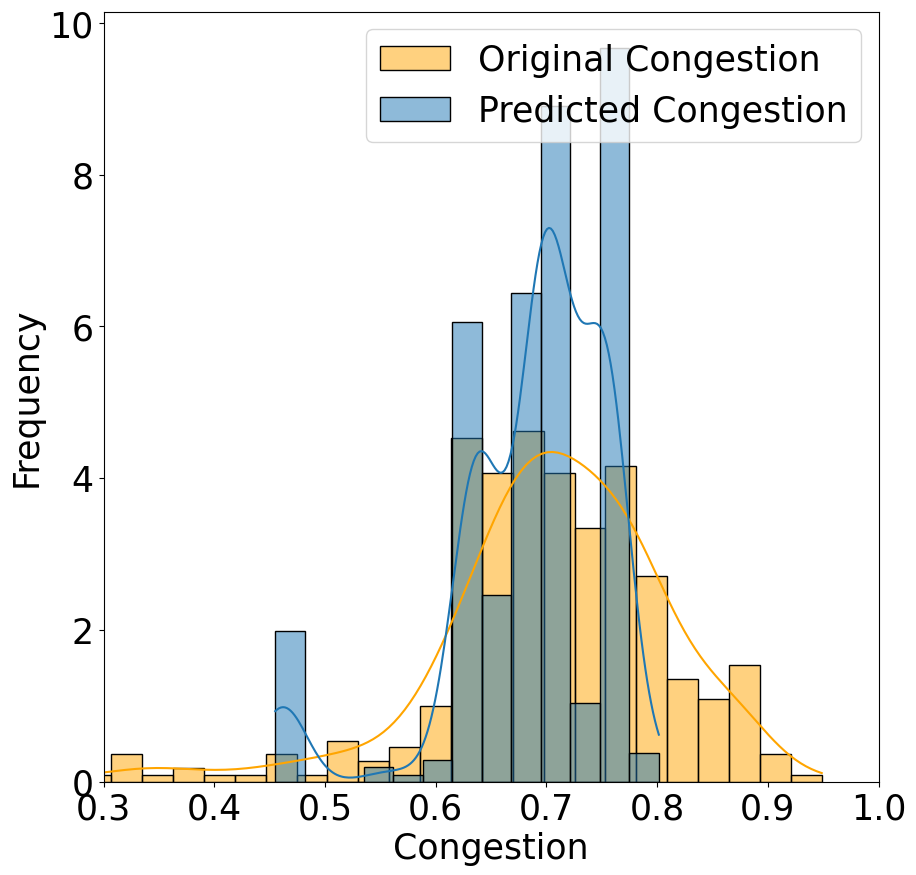

In [543]:
plt.figure(figsize=(10, 10))
sns.histplot(data[0].y[degree_data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(degree_pred, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Original vs Predicted Congestion')
plt.xlim(0.3, 1)
plt.legend(fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25) 
plt.show()

In [544]:
degree_inversed = congestion_scaler.inverse_transform(test_pred)
degree_mse = mean_squared_error(instance_lst[0][['congestion']].values[degree_data.test_mask], degree_inversed)
degree_mse

33.18874865142532

In [546]:
# Assuming `true_values` are your actual congestion values and `predicted_values` are the values predicted by your model
degree_true_values = data[0].y[degree_data.test_mask].cpu().detach().numpy()  # Replace with actual reference to your true congestion values
degree_predicted_values = np.array(degree_pred.flatten())  # Make sure this is a flat array of predictions

# Correlation coefficient
degree_correlation_matrix = np.corrcoef(degree_true_values, degree_predicted_values)
degree_correlation_coefficient = degree_correlation_matrix[0, 1]

# Coefficient of determination, R^2
degree_coefficient_of_determination = np.square(degree_correlation_coefficient)

print(f'Correlation Coefficient (Pearson\'s r): {degree_correlation_coefficient}')
print(f'Coefficient of Determination (R²): {degree_coefficient_of_determination}')


Correlation Coefficient (Pearson's r): -0.004056666918720833
Coefficient of Determination (R²): 1.6456546489443982e-05
